# Powertrain for UAV

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import gym
from systems.powertrain import *
np.random.seed(43)

### The Continuous Battery Cell

In [3]:
battery_coefficients = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')
cbcell = ContinuousBatteryCell(**battery_coefficients)

### Simulate continuous cell until eod
- under varying load
- under constant load (3.8695 A, representing 1 hr of use)

In [4]:
print("age: " + str(cbcell.age))

# timestep for ode solver
cbcell.period = 1.0
#cbcell.period = .05
ct = 1/3600*cbcell.period 
t1 = cbcell.nsteps(ct)


varying_load = True

if varying_load:
    x = np.linspace(0, 2*np.pi, int(cbcell.z*100)+1)
    y = np.sin(2*-x**1.1)/4+8

    
q_vals = []
t_vals = []
run_num = 1
while(cbcell.age < cbcell.eol - 1):
    # data holders for current, soc, noisy soc, filtered soc, voltage
    cs, cz, cn, cf, cv = [], [], [], [], []
    i = 0
    # random current profile for a given run
    amp = np.random.uniform(1,2)
    pwr = np.random.uniform(.8, 1.4)
    fct = np.random.uniform(3,5)
    ofs = np.random.uniform(3,5)
    y = np.sin(amp*-x**pwr)/fct+ofs
    done = False
    while(not done):
        if varying_load:
            c = np.random.normal(y[int(cbcell.z*100)], .1)
        else:
            c = 3.8695
        obs, reward, done, info = cbcell.step(t1, c)
        cs.append(c)
        cz.append(cbcell.z)
        cn.append(obs[0])
        cf.append(obs[1])
        #print(obs)
        cv.append(cbcell.ocv)
        i += 1

    t = int(i*cbcell.period)
#     print("elapsed seconds: {:.2f}".format(t))
#     print("ending soc: {:.4f}".format(cbcell.z))
#     print("cycle time: {:.2f}".format(cbcell.cycle_time))
    print("run: {}\tQ: {:.4f}\tavg_load: {:.4f}\tcycle_time: {}\tage: {:.4f}\teol: {}".format(run_num, cbcell.Q, cbcell.avg_load, int(cbcell.cycle_time), cbcell.age, int(cbcell.eol)))
    run_num += 1
    q_vals.append(cbcell.Q)
    t_vals.append(int(cbcell.cycle_time))
#     factor = 1/60*cbcell.period
#     X = np.arange(0, i)*factor
#     three_plot(title="Continuous Battery Cell Discharge Plots", figsize=(12,4), 
#                plot1=np.array([X, np.array(cs)]),
#                plot2=np.array([X, cv]), 
#                plot3=np.array([X[0:80], cn[0:80],X[0:80], cf[0:80],X[0:80], cz[0:80]], dtype=object),
#                label1=["current profile"],
#                label2=["continuous voltage"],
#                label3=["observed soc", "filtered soc", "actual soc"],
#                title1="Current Draw",
#                title2="Open Circuit Voltage",
#                title3="State of Charge",
#                axes1=['time (minutes)', 'current (A)'],
#                axes2=['time (minutes)', 'ocv (V)'],
#                axes3=['time (minutes)', 'soc (%)'],
#                save=False,
#                filename="figures/figures/continuousBatteryPlots.png")
    cbcell.reset()
    

age: 0.0
run: 1	Q: 3.8695	avg_load: 3.4010	cycle_time: 4016	age: 0.7198	eol: 320
run: 2	Q: 3.8657	avg_load: 3.8677	cycle_time: 3526	age: 1.6522	eol: 320
run: 3	Q: 3.8651	avg_load: 3.5923	cycle_time: 3796	age: 2.4566	eol: 320
run: 4	Q: 3.8646	avg_load: 3.6153	cycle_time: 3773	age: 3.2711	eol: 320
run: 5	Q: 3.8640	avg_load: 3.6400	cycle_time: 3746	age: 4.0970	eol: 320
run: 6	Q: 3.8634	avg_load: 3.7456	cycle_time: 3639	age: 4.9719	eol: 320
run: 7	Q: 3.8628	avg_load: 4.4859	cycle_time: 3035	age: 6.2283	eol: 320
run: 8	Q: 3.8619	avg_load: 3.1239	cycle_time: 4366	age: 6.8364	eol: 320
run: 9	Q: 3.8614	avg_load: 4.6711	cycle_time: 2912	age: 8.1999	eol: 320
run: 10	Q: 3.8604	avg_load: 4.6025	cycle_time: 2955	age: 9.5238	eol: 320
run: 11	Q: 3.8593	avg_load: 3.0536	cycle_time: 4462	age: 10.1055	eol: 320
run: 12	Q: 3.8588	avg_load: 4.2290	cycle_time: 3216	age: 11.2232	eol: 320
run: 13	Q: 3.8578	avg_load: 3.7640	cycle_time: 3616	age: 12.1080	eol: 320
run: 14	Q: 3.8570	avg_load: 4.7710	cycle_time: 2

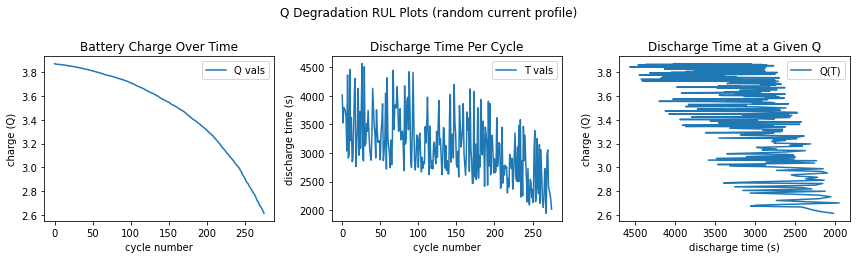

In [5]:
three_plot(title="Q Degradation RUL Plots (random current profile)", figsize=(12,4), 
           plot1=np.array([np.arange(0, len(q_vals)), np.array(q_vals)]),
           plot2=np.array([np.arange(0, len(t_vals)), np.array(t_vals)]), 
           plot3=np.array([np.array(t_vals), np.array(q_vals)]),
           label1=["Q vals"],
           label2=["T vals"],
           label3=["Q(T)"],
           title1="Battery Charge Over Time",
           title2="Discharge Time Per Cycle",
           title3="Discharge Time at a Given Q",
           axes1=['cycle number', 'charge (Q)'],
           axes2=['cycle number', 'discharge time (s)'],
           axes3=['discharge time (s)', 'charge (Q)'],
           invert = [0,0,1],
           save=True,
           filename="figures/rul_plots_random_load.png")

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(np.array(t_vals))
ax2 = ax1.twinx()
ax2.plot(np.array(q_vals))
plt.show()

### plot the battery profile curves
- q degradation
- r0 degradation
- soc ocv curve

In [ ]:
# shows that profile curves are continuous
print(cbcell.get_v(z=45.32434))
print(cbcell.get_r0(age=123.232))
print(cbcell.get_q(age=.973))

plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol)))
plt.title('q degradation')
plt.ylabel('Q (A)')
plt.xlabel('steps (continuous space)')
plt.show()
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol)))
plt.title('R0 degradation')
plt.ylabel('R0 (ohms)')
plt.xlabel('steps (continuous space)')
plt.show()
plt.plot(np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101)))
plt.title('soc ocv curve')
plt.ylabel('OCV (V)')
plt.xlabel('SOC (%) (continuous space)')
plt.show()

### The Discrete Battery Cell

In [ ]:
class DiscreteBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(DiscreteBatteryCell, self).__init__(*args, **kwargs)
        self.soc_ocv = kwargs['soc_ocv']
        
    def get_ocv(self):
        if(self.z < 0.0):
            self.z = 0
        elif(self.z > 1.0):
            self.z = 1.0
        idx = int(np.ceil(self.z*100))
        if(idx > 101):
            idx = 101
        elif(idx < 1):
            idx = 1
        return self.soc_ocv[idx]
        
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.z = self.z - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current
        

In [ ]:
dbcell = DiscreteBatteryCell(**battery_coefficients)

In [ ]:
x = np.array([1,2,3,4])
y = np.array([1,2,3,4,5,9])
avgy = np.sum(y)/len(y)
print(avgy)
avg = np.sum(x)/len(x)
print(avg)
num = 5
count = len(x)
avg = (num + count*avg)/(count+1)
print(avg)
count +=1
num = 9
avg = (num + count*avg)/(count+1)
count += 1
print(avg)

### Simulate and compare cells
- dt = 1 second, current = 3.8695
- the cell capacity is 3.8695 mAh, so, i should be ~3600 
- the cell asymptotically approaches the eod, so have to stop slightly above

![battery comparison image](figures/batteryComparison.png "Battery Comparison")